In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters * 4, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, strides=2)
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Training for potentially many epochs, but with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,  # Train potentially for many epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[early_stopping]  # Pass the early stopping callback
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)



Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/20


375/375 [==============================] - 1086s 2s/step - loss: 3.4205 - accuracy: 0.1446 - val_loss: 6.5941 - val_accuracy: 0.0453
Epoch 2/20
375/375 [==============================] - 738s 2s/step - loss: 1.1308 - accuracy: 0.6578 - val_loss: 24.9584 - val_accuracy: 0.6837
Epoch 3/20
375/375 [==============================] - 743s 2s/step - loss: 0.5541 - accuracy: 0.8324 - val_loss: 0.6493 - val_accuracy: 0.7983
Epoch 4/20
375/375 [==============================] - 664s 2s/step - loss: 0.3820 - accuracy: 0.8822 - val_loss: 168.3391 - val_accuracy: 0.3780
Epoch 5/20
375/375 [==============================] - 568s 2s/step - loss: 0.3843 - accuracy: 0.8792 - val_loss: 0.3945 - val_accuracy: 0.8807
Epoch 6/20
375/375 [==============================] - 472s 1s/step - loss: 0.2722 - accuracy: 0.9153 - val_loss: 0.4156 - val_accuracy: 0.8820
Epoch 7/20
375/375 [=========================

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/30
375/375 [==============================] - 185s 443ms/step - loss: 3.5734 - accuracy: 0.1068 - val_loss: 4.9853 - val_accuracy: 0.0563
Epoch 2/30
375/375 [==============================] - 171s 457ms/step - loss: 1.2545 - accuracy: 0.6227 - val_loss: 1.5661 - val_accuracy: 0.5863
Epoch 3/30
375/375 [==============================] - 172s 459ms/step - loss: 0.6802 - accuracy: 0.7981 - val_loss: 14.0585 - val_accuracy: 0.7177
Epoch 4/30
375/375 [==============================] - 174s 464ms/step - loss: 0.4970 - accuracy: 0.8462 - val_loss: 2.4449 - val_accuracy: 0.5780
Epoch 5/30
375/375 [==============================] - 164s 438ms/step - loss: 0.5402 - accuracy: 0.8338 - val_loss: 0.3398 - val_accuracy: 0.8997
Epoch 6/30
375/375 [==============================] - 164s 437ms/step - loss: 0.3366 - accuracy: 0.8918 - val_loss: 0.6294 - val_accuracy: 0.8333
Epoch 7/30
375/375 [================

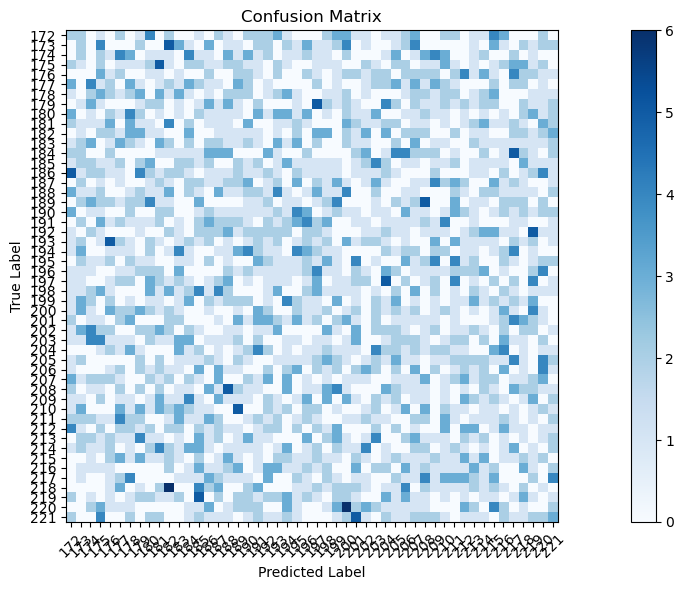

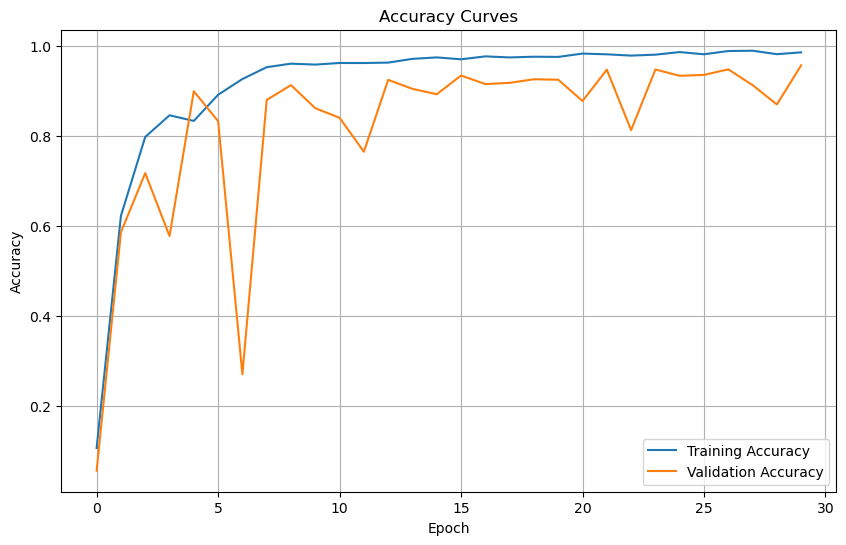

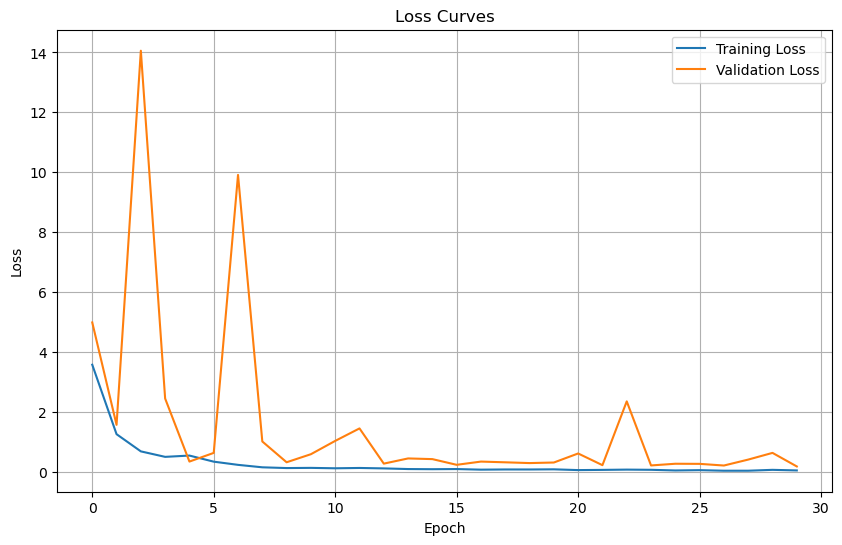

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters * 4, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)

x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)
x = residual_block(x, filters=128)

x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)
x = residual_block(x, filters=256)

x = residual_block(x, filters=512, strides=2)
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training for 30 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=30,  # Train for 30 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(15, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
